# Bibliotecas

In [ ]:
# Manipulação e estruturação
import pandas as pd
import numpy as np

# Modelagem
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV

# Avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Pré-processamento
from sklearn.preprocessing import StandardScaler

# Visualização
import matplotlib.pyplot as plt



# Preparação dos Dados

In [ ]:
df = pd.read_csv("../../camada_ouro/Join_dataframes_new_end.csv", parse_dates=["Date"])
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [565]:
# Limpeza de colunas com %
df['Change%_Petro'] = df['Change%_Petro'].str.replace('%', '').astype(float) / 100
df['Value_IPCA'] = df['Value_IPCA'].str.replace('%', '').astype(float) / 100
df['Change%_Ibovespa'] = df['Change%_Ibovespa'].astype("str")
df['Change%_Ibovespa'] = df['Change%_Ibovespa'].str.replace('%', '').astype(float) / 100

display(df)

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA
0,2010-01-04,2010-01-04 16:56:00,37.937621,13303743.87,22.005581,81.51,263.54,0.0271,70045.08,0.003999,0.0075
1,2010-01-05,2010-01-05 16:56:00,37.774220,21396519.48,21.927335,81.77,258.89,0.0032,70239.82,-0.037754,0.0075
2,2010-01-06,2010-01-06 16:56:00,38.805357,18720547.15,22.382971,83.18,370.06,0.0172,70729.34,-0.025855,0.0075
3,2010-01-07,2010-01-07 16:56:00,36.425929,10964646.19,20.918813,82.66,246.63,-0.0063,70451.12,0.012930,0.0075
4,2010-01-08,2010-01-08 16:56:00,35.037787,14624078.31,20.148239,82.75,310.38,0.0011,70262.70,0.013341,0.0075
...,...,...,...,...,...,...,...,...,...,...,...
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052


In [566]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3631 entries, 0 to 3630
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               3631 non-null   datetime64[ns]
 1   Datetime           3631 non-null   object        
 2   Close_Real_EYAC2   3631 non-null   float64       
 3   Volume_EYAC2       3631 non-null   float64       
 4   Close_Dolar_EYAC2  3631 non-null   float64       
 5   Price_Dolar_Petro  3631 non-null   float64       
 6   Volume_Petro       3631 non-null   float64       
 7   Change%_Petro      3631 non-null   float64       
 8   Índice_Ibovespa    3631 non-null   float64       
 9   Change%_Ibovespa   3631 non-null   float64       
 10  Value_IPCA         3631 non-null   float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 312.2+ KB


Alvo

In [567]:
df['target'] = df['Close_Real_EYAC2'].shift(-1)  # prever o preço da ação no próximo dia

# Feature Engineering 

### Retornos percentuais diários

In [568]:
df['retorno_acao'] = df['Close_Real_EYAC2'].pct_change()
df['retorno_petro'] = df['Price_Dolar_Petro'].pct_change()
df['retorno_ibov'] = df['Índice_Ibovespa'].pct_change()

df.tail()


,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,retorno_ibov
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052,39.320157,0.073694,-0.005189,0.007544
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052,37.867609,0.012217,-0.003043,-0.010938
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052,36.066818,-0.036942,0.006104,0.002575
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052,36.614223,-0.047555,0.013722,-0.006675
3630,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-0.079271,0.0052,NaN,0.015178,0.004987,0.000117


### Médias móveis de 7 dias

In [569]:
df['mm7_acao'] = df['Close_Real_EYAC2'].rolling(7).mean()
df['mm7_petro'] = df['Price_Dolar_Petro'].rolling(7).mean()

df.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,retorno_ibov,mm7_acao,mm7_petro
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052,39.320157,0.073694,-0.005189,0.007544,36.752494,69.834286
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052,37.867609,0.012217,-0.003043,-0.010938,36.891896,69.712857
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052,36.066818,-0.036942,0.006104,0.002575,37.193168,69.485714
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052,36.614223,-0.047555,0.013722,-0.006675,36.978142,69.470000
3630,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-0.079271,0.0052,NaN,0.015178,0.004987,0.000117,37.267763,69.595714


### Volatilidade

In [570]:
df['vol_7_acao'] = df['Close_Real_EYAC2'].rolling(7).std()
df['vol_7_ibov'] = df['Índice_Ibovespa'].rolling(7).std()

df.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,retorno_ibov,mm7_acao,mm7_petro,vol_7_acao,vol_7_ibov
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052,39.320157,0.073694,-0.005189,0.007544,36.752494,69.834286,1.537777,1981.106276
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052,37.867609,0.012217,-0.003043,-0.010938,36.891896,69.712857,1.737403,1745.564657
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052,36.066818,-0.036942,0.006104,0.002575,37.193168,69.485714,1.690363,1541.639762
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052,36.614223,-0.047555,0.013722,-0.006675,36.978142,69.470000,1.729424,1496.034375
3630,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-0.079271,0.0052,NaN,0.015178,0.004987,0.000117,37.267763,69.595714,1.400747,628.244633


### Defasagens

In [571]:
df['lag1_acao'] = df['Close_Real_EYAC2'].shift(1)
df['lag7_acao'] = df['Close_Real_EYAC2'].shift(7)
df['lag30_acao'] = df['Close_Real_EYAC2'].shift(30)
df['lag90_acao'] = df['Close_Real_EYAC2'].shift(90)
df['lag1_petro'] = df['Price_Dolar_Petro'].shift(1)
df['lag1_ibov'] = df['Índice_Ibovespa'].shift(1)
df['lag1_ipca'] = df['Value_IPCA'].shift(1)

df.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,...,mm7_petro,vol_7_acao,vol_7_ibov,lag1_acao,lag7_acao,lag30_acao,lag90_acao,lag1_petro,lag1_ibov,lag1_ipca
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,...,69.834286,1.537777,1981.106276,36.179398,41.012756,35.481546,38.442778,69.38,121187.91,0.0052
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,...,69.712857,1.737403,1745.564657,38.845595,38.344346,35.474189,37.702588,69.02,122102.15,0.0052
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,...,69.485714,1.690363,1541.639762,39.320157,35.758705,36.445515,36.414144,68.81,120766.57,0.0052
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,...,69.470000,1.729424,1496.034375,37.867609,37.572001,34.565874,37.483403,69.23,121077.50,0.0052
3630,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-0.079271,...,69.595714,1.400747,628.244633,36.066818,34.586871,38.741735,37.969977,70.18,120269.31,0.0052


In [572]:
df_test = df[['Date','target','retorno_acao', 'mm7_acao', 'vol_7_acao', 'lag1_acao','lag7_acao','lag30_acao', 'lag90_acao' ]]
display(df_test)
# df_test.to_csv('../../camada_ouro/target.csv', index=False)

,Date,target,retorno_acao,mm7_acao,vol_7_acao,lag1_acao,lag7_acao,lag30_acao,lag90_acao
0,2010-01-04,37.774220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,38.805357,-0.004307,NaN,NaN,37.937621,NaN,NaN,NaN
2,2010-01-06,36.425929,0.027297,NaN,NaN,37.774220,NaN,NaN,NaN
3,2010-01-07,35.037787,-0.061317,NaN,NaN,38.805357,NaN,NaN,NaN
4,2010-01-08,36.103721,-0.038109,NaN,NaN,36.425929,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3626,2024-12-20,39.320157,0.073694,36.752494,1.537777,36.179398,41.012756,35.481546,38.442778
3627,2024-12-23,37.867609,0.012217,36.891896,1.737403,38.845595,38.344346,35.474189,37.702588
3628,2024-12-26,36.066818,-0.036942,37.193168,1.690363,39.320157,35.758705,36.445515,36.414144
3629,2024-12-27,36.614223,-0.047555,36.978142,1.729424,37.867609,37.572001,34.565874,37.483403


# Tratamento dos dados

Essas transformações geram valores NaN no início da série, por exemplo:

pct_change() → NaN na primeira linha

rolling(7).mean() → NaN nas 6 primeiras linhas

shift(1) → NaN na primeira linha

Esses NaNs atrapalham o treino do modelo e precisam ser removidos antes de separar treino/teste ou aplicar model.fit().

In [573]:
# Copiar o DataFrame original para df_model
df_nan = df.copy()

# Preencher os valores NaN nas variáveis de lag com interpolação linear
df_nan[['lag1_acao', 'lag7_acao', 'lag30_acao', 'lag90_acao']] = df_nan[['lag1_acao', 'lag7_acao', 'lag30_acao', 'lag90_acao']].interpolate(method='linear')

# Preencher as variáveis de médias móveis (mm), volatilidade (vol), e retornos com interpolação linear
df_nan[['mm7_acao', 'mm7_petro']] = df_nan[['mm7_acao', 'mm7_petro']].interpolate(method='linear')
df_nan[['vol_7_acao', 'vol_7_ibov']] = df_nan[['vol_7_acao', 'vol_7_ibov']].interpolate(method='linear')
df_nan[['retorno_acao', 'retorno_petro', 'retorno_ibov']] = df_nan[['retorno_acao', 'retorno_petro', 'retorno_ibov']].interpolate(method='linear')

# Preencher os lags adicionais (lag1_ibov, lag1_petro, lag1_ipca) com interpolação linear
df_nan[['lag1_ibov', 'lag1_petro', 'lag1_ipca']] = df_nan[['lag1_ibov', 'lag1_petro', 'lag1_ipca']].interpolate(method='linear')

# Preencher os NaN restantes usando o valor anterior (bfill)
df_nan[['lag1_acao', 'lag7_acao', 'lag30_acao', 'lag90_acao', 'mm7_acao', 'mm7_petro', 'vol_7_acao', 'vol_7_ibov', 
          'retorno_acao', 'retorno_petro', 'retorno_ibov', 'lag1_ibov', 'lag1_petro', 'lag1_ipca']] = \
df_nan[['lag1_acao', 'lag7_acao', 'lag30_acao', 'lag90_acao', 'mm7_acao', 'mm7_petro', 'vol_7_acao', 'vol_7_ibov', 
          'retorno_acao', 'retorno_petro', 'retorno_ibov', 'lag1_ibov', 'lag1_petro', 'lag1_ipca']].fillna(method='bfill')

# Verificar se ainda há NaN após interpolação e preenchimento com ffill e iloc
nan_counts_after_filling = df_nan[['lag1_acao', 'lag7_acao', 'lag30_acao', 'lag90_acao', 'mm7_acao', 'mm7_petro', 
                                     'vol_7_acao', 'vol_7_ibov', 'retorno_acao', 'retorno_petro', 'retorno_ibov', 
                                     'lag1_ibov', 'lag1_petro', 'lag1_ipca']].isna().sum()

print("Após interpolação, ffill e preenchimento com iloc, contagem de NaN:", nan_counts_after_filling)

# Visualizar as primeiras linhas após o preenchimento
print(df_nan.head())

# Salvar o DataFrame resultante em um arquivo CSV
df_nan.to_csv('../../camada_ouro/teste_completo.csv', index=False)


Após interpolação, ffill e preenchimento com iloc, contagem de NaN: lag1_acao        0
lag7_acao        0
lag30_acao       0
lag90_acao       0
mm7_acao         0
mm7_petro        0
vol_7_acao       0
vol_7_ibov       0
retorno_acao     0
retorno_petro    0
retorno_ibov     0
lag1_ibov        0
lag1_petro       0
lag1_ipca        0
dtype: int64
        Date             Datetime  Close_Real_EYAC2  Volume_EYAC2  \
0 2010-01-04  2010-01-04 16:56:00         37.937621   13303743.87   
1 2010-01-05  2010-01-05 16:56:00         37.774220   21396519.48   
2 2010-01-06  2010-01-06 16:56:00         38.805357   18720547.15   
3 2010-01-07  2010-01-07 16:56:00         36.425929   10964646.19   
4 2010-01-08  2010-01-08 16:56:00         35.037787   14624078.31   

   Close_Dolar_EYAC2  Price_Dolar_Petro  Volume_Petro  Change%_Petro  \
0          22.005581              81.51        263.54         0.0271   
1          21.927335              81.77        258.89         0.0032   
2          22.382971  

C:\Users\FM972EJ\AppData\Local\Temp\ipykernel_24108\2664773565.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  'retorno_acao', 'retorno_petro', 'retorno_ibov', 'lag1_ibov', 'lag1_petro', 'lag1_ipca']].fillna(method='bfill')


In [610]:
df_nan.isna().sum()

Date                 0
Datetime             0
Close_Real_EYAC2     0
Volume_EYAC2         0
Close_Dolar_EYAC2    0
Price_Dolar_Petro    0
Volume_Petro         0
Change%_Petro        0
Índice_Ibovespa      0
Change%_Ibovespa     0
Value_IPCA           0
target               1
retorno_acao         0
retorno_petro        0
retorno_ibov         0
mm7_acao             0
mm7_petro            0
vol_7_acao           0
vol_7_ibov           0
lag1_acao            0
lag7_acao            0
lag30_acao           0
lag90_acao           0
lag1_petro           0
lag1_ibov            0
lag1_ipca            0
dtype: int64

In [575]:
df_model = df_nan.dropna().copy()   

df_model.tail(2)
# df_model.to_csv('../../camada_ouro/teste.csv')

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,...,mm7_petro,vol_7_acao,vol_7_ibov,lag1_acao,lag7_acao,lag30_acao,lag90_acao,lag1_petro,lag1_ibov,lag1_ipca
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,...,69.485714,1.690363,1541.639762,39.320157,35.758705,36.445515,36.414144,68.81,120766.57,0.0052
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,...,69.470000,1.729424,1496.034375,37.867609,37.572001,34.565874,37.483403,69.23,121077.50,0.0052


In [576]:
df_model.isna().sum()

Date                 0
Datetime             0
Close_Real_EYAC2     0
Volume_EYAC2         0
Close_Dolar_EYAC2    0
Price_Dolar_Petro    0
Volume_Petro         0
Change%_Petro        0
Índice_Ibovespa      0
Change%_Ibovespa     0
Value_IPCA           0
target               0
retorno_acao         0
retorno_petro        0
retorno_ibov         0
mm7_acao             0
mm7_petro            0
vol_7_acao           0
vol_7_ibov           0
lag1_acao            0
lag7_acao            0
lag30_acao           0
lag90_acao           0
lag1_petro           0
lag1_ibov            0
lag1_ipca            0
dtype: int64

In [577]:
df_test1 = df_model[['Date','target','retorno_acao', 'mm7_acao', 'vol_7_acao', 'lag1_acao','lag7_acao','lag30_acao', 'lag90_acao' ]]
display(df_test1)


df_test.to_csv('../../camada_ouro/target.csv', index=False)

,Date,target,retorno_acao,mm7_acao,vol_7_acao,lag1_acao,lag7_acao,lag30_acao,lag90_acao
0,2010-01-04,37.774220,-0.004307,37.327009,1.518331,37.937621,37.937621,37.937621,37.937621
1,2010-01-05,38.805357,-0.004307,37.327009,1.518331,37.937621,37.937621,37.937621,37.937621
2,2010-01-06,36.425929,0.027297,37.327009,1.518331,37.774220,37.937621,37.937621,37.937621
3,2010-01-07,35.037787,-0.061317,37.327009,1.518331,38.805357,37.937621,37.937621,37.937621
4,2010-01-08,36.103721,-0.038109,37.327009,1.518331,36.425929,37.937621,37.937621,37.937621
...,...,...,...,...,...,...,...,...,...
3625,2024-12-19,38.845595,0.005527,37.062089,2.132540,35.980543,39.035292,34.248127,36.096128
3626,2024-12-20,39.320157,0.073694,36.752494,1.537777,36.179398,41.012756,35.481546,38.442778
3627,2024-12-23,37.867609,0.012217,36.891896,1.737403,38.845595,38.344346,35.474189,37.702588
3628,2024-12-26,36.066818,-0.036942,37.193168,1.690363,39.320157,35.758705,36.445515,36.414144


In [578]:

data_reduced = df_model.drop(columns=['Date','Datetime'])

# Calcular a variabilidade (desvio padrão) das features numéricas restantes
variability = data_reduced.std()

# Calcular a correlação entre as features
correlation_matrix = data_reduced.corr()

# Exibir a variabilidade
print("Variabilidade das Features:")
display(variability)

# Exibir a matriz de correlação
print("Matriz de Correlação das Features:")
display(correlation_matrix)

Variabilidade das Features:


Close_Real_EYAC2     8.355212e+00
Volume_EYAC2         3.241283e+07
Close_Dolar_EYAC2    3.895470e+00
Price_Dolar_Petro    2.098516e+01
Volume_Petro         1.660087e+02
Change%_Petro        2.724452e-02
Índice_Ibovespa      2.752411e+04
Change%_Ibovespa     8.946320e-02
Value_IPCA           3.609585e-03
target               8.354574e+00
retorno_acao         1.334234e-01
retorno_petro        2.455251e-02
retorno_ibov         1.491358e-02
mm7_acao             8.214106e+00
mm7_petro            2.092375e+01
vol_7_acao           4.926798e-01
vol_7_ibov           7.264548e+02
lag1_acao            8.356097e+00
lag7_acao            8.358193e+00
lag30_acao           8.348511e+00
lag90_acao           8.383935e+00
lag1_petro           2.098579e+01
lag1_ibov            2.751722e+04
lag1_ipca            3.609871e-03
dtype: float64

Matriz de Correlação das Features:


,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,...,mm7_petro,vol_7_acao,vol_7_ibov,lag1_acao,lag7_acao,lag30_acao,lag90_acao,lag1_petro,lag1_ibov,lag1_ipca
Close_Real_EYAC2,1.000000,-0.015574,0.429409,0.366131,-0.353437,0.003342,0.783965,0.122858,-0.102776,0.966103,...,0.362644,0.087551,0.127837,0.966109,0.950566,0.898435,0.807579,0.364444,0.783337,-0.103618
Volume_EYAC2,-0.015574,1.000000,-0.430554,-0.282602,0.001013,0.031350,0.268353,-0.073720,0.050002,-0.017194,...,-0.280507,0.172080,0.451897,-0.005848,-0.000392,0.012578,-0.025446,-0.282733,0.269560,0.046743
Close_Dolar_EYAC2,0.429409,-0.430554,1.000000,0.583168,-0.087977,-0.012152,-0.152875,0.070683,-0.051955,0.403781,...,0.582501,0.001584,-0.151230,0.407494,0.408262,0.416810,0.459885,0.582436,-0.152818,-0.052068
Price_Dolar_Petro,0.366131,-0.282602,0.583168,1.000000,-0.289808,-0.008427,-0.037469,0.028943,0.051523,0.364213,...,0.995219,0.036533,-0.155700,0.366231,0.366824,0.364296,0.333278,0.997165,-0.036915,0.053288
Volume_Petro,-0.353437,0.001013,-0.087977,-0.289808,1.000000,0.008648,-0.334465,-0.057120,0.008408,-0.354266,...,-0.287598,-0.017970,-0.087167,-0.347458,-0.343063,-0.338537,-0.317239,-0.288142,-0.333487,0.010204
Change%_Petro,0.003342,0.031350,-0.012152,-0.008427,0.008648,1.000000,0.014480,0.010462,-0.004649,0.006515,...,-0.054585,-0.016471,-0.041268,-0.017846,-0.020047,-0.024969,-0.000009,-0.066689,0.003342,-0.009778
Índice_Ibovespa,0.783965,0.268353,-0.152875,-0.037469,-0.334465,0.014480,1.000000,0.116297,-0.057654,0.784059,...,-0.041911,0.090593,0.266967,0.782087,0.770382,0.718249,0.606805,-0.038931,0.999074,-0.059068
Change%_Ibovespa,0.122858,-0.073720,0.070683,0.028943,-0.057120,0.010462,0.116297,1.000000,-0.027156,0.123892,...,0.015320,0.009637,-0.204279,0.119191,0.078560,-0.070264,-0.034319,0.024780,0.110342,-0.035590
Value_IPCA,-0.102776,0.050002,-0.051955,0.051523,0.008408,-0.004649,-0.057654,-0.027156,1.000000,-0.103961,...,0.043537,-0.061832,-0.047888,-0.101458,-0.095614,-0.083758,-0.094863,0.049102,-0.056650,0.979234
target,0.966103,-0.017194,0.403781,0.364213,-0.354266,0.006515,0.784059,0.123892,-0.103961,1.000000,...,0.360940,0.084746,0.126622,0.961947,0.947785,0.896468,0.806795,0.362574,0.783549,-0.104842


# Definindo Features e Target

In [580]:
# Atualizando as features
feature_names = [
    'lag1_acao',  # Mantido por ser o lag mais recente e relevante
    'retorno_acao',  # Retorno da ação
    'retorno_petro',  # Retorno do petróleo
    'mm7_acao',  # Média móvel de 7 dias da ação
    'vol_7_acao',  # Volatilidade de 7 dias da ação
    'Price_Dolar_Petro',  # Preço do petróleo
    'Índice_Ibovespa',  # Índice Ibovespa
]

# Definindo X (features) e y (target)
X = df_model[feature_names]
y = df_model['target']

# Padronização

In [581]:
# Inicializando o scaler
scaler = StandardScaler()

# Padronizando as features
X_scaled = scaler.fit_transform(X)

# Separar Treino e teste

In [582]:
split_date = '2022-01-01'

train = df_model[df_model['Date'] < split_date]     # Treinamento: 2010–2021
test = df_model[df_model['Date'] >= split_date]     # Teste: 2022–2024

X_train = train[feature_names]
y_train = train['target']
X_test = test[feature_names]
y_test = test['target']

# Padronizando os dados de treino e teste
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Treinamento e Validação

### RandomForest

In [558]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Avaliação de desempenho
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest - MAE:", mae_rf)
print("Random Forest - RMSE:", rmse_rf)
print("Random Forest - R²:", r2_rf)


Random Forest - MAE: 2.0039055958463803
Random Forest - RMSE: 2.5860132344597906
Random Forest - R²: 0.7555498863534972


### LinearRegression

In [559]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# Avaliação de desempenho
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression - MAE:", mae_lr)
print("Linear Regression - RMSE:", rmse_lr)
print("Linear Regression - R²:", r2_lr)


Linear Regression - MAE: 1.5520845327412944
Linear Regression - RMSE: 1.9539291860810497
Linear Regression - R²: 0.860444679868197


### RidgeRegression

In [560]:
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Avaliação de desempenho
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression - MAE:", mae_ridge)
print("Ridge Regression - RMSE:", rmse_ridge)
print("Ridge Regression - R²:", r2_ridge)


Ridge Regression - MAE: 1.551639894094853
Ridge Regression - RMSE: 1.9534576723344368
Ridge Regression - R²: 0.8605120255148727


### LassoRegression

In [561]:
lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Avaliação de desempenho
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression - MAE:", mae_lasso)
print("Lasso Regression - RMSE:", rmse_lasso)
print("Lasso Regression - R²:", r2_lasso)


Lasso Regression - MAE: 2.495232233107349
Lasso Regression - RMSE: 3.0091371156719573
Lasso Regression - R²: 0.6690116468013861


### XGBoost

In [562]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Avaliação de desempenho
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost - MAE:", mae_xgb)
print("XGBoost - RMSE:", rmse_xgb)
print("XGBoost - R²:", r2_xgb)


XGBoost - MAE: 2.593668560278536
XGBoost - RMSE: 3.2803077060440007
XGBoost - R²: 0.6066692270115545


### Comparação entre modelos

In [583]:
# Criar um DataFrame para comparar as métricas
results = pd.DataFrame({
    'Model': ['Random Forest', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'XGBoost'],
    'MAE': [mae_rf, mae_lr, mae_ridge, mae_lasso, mae_xgb],
    'RMSE': [rmse_rf, rmse_lr, rmse_ridge, rmse_lasso, rmse_xgb],
    'R²': [r2_rf, r2_lr, r2_ridge, r2_lasso, r2_xgb]
})

display(results)

,Model,MAE,RMSE,R²
0,Random Forest,2.003906,2.586013,0.755550
1,Linear Regression,1.552085,1.953929,0.860445
2,Ridge Regression,1.551640,1.953458,0.860512
3,Lasso Regression,2.495232,3.009137,0.669012
4,XGBoost,2.593669,3.280308,0.606669


### Validação cruzada temporal

In [483]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definindo TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # 5 divisões

# Função para avaliar cada modelo com TimeSeriesSplit
def evaluate_model_with_ts_split(model, X_train, y_train):
    mae_list = []
    rmse_list = []
    r2_list = []

    for train_index, val_index in tscv.split(X_train):
        X_train_split, X_val_split = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_split, y_val_split = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Treinando o modelo
        model.fit(X_train_split, y_train_split)
        
        # Fazendo previsões
        y_pred = model.predict(X_val_split)
        
        # Calculando as métricas
        mae = mean_absolute_error(y_val_split, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))
        r2 = r2_score(y_val_split, y_pred)
        
        # Armazenando as métricas para o split
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
    # Calculando as médias das métricas
    mean_mae = np.mean(mae_list)
    mean_rmse = np.mean(rmse_list)
    mean_r2 = np.mean(r2_list)
    
    return mean_mae, mean_rmse, mean_r2

# Avaliação de cada modelo com TimeSeriesSplit
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Armazenando os resultados
results = []

# Avaliar todos os modelos
for name, model in models.items():
    mae, rmse, r2 = evaluate_model_with_ts_split(model, X_train, y_train)
    results.append([name, mae, rmse, r2])

# Criando um DataFrame com os resultados
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R²'])
display(results_df)


c:\Users\FM972EJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.03671e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\FM972EJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.83981e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\FM972EJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.31482e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\FM972EJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.0877e-18): result may not be accurate.
  return linal

,Model,MAE,RMSE,R²
0,Random Forest,2.480727,2.976024,0.329668
1,Linear Regression,1.573844,1.969979,0.712085
2,Ridge Regression,1.514338,1.888009,0.734496
3,Lasso Regression,2.248161,2.697308,0.448421
4,XGBoost,3.110354,3.692882,-0.131778


Fitting 5 folds for each of 75 candidates, totalling 375 fits
Melhores Parâmetros: {'alpha': 0.01, 'max_iter': 1000, 'solver': 'lsqr'}
Ridge Regression (Otimizado) - MAE: 1.552079722749796
Ridge Regression (Otimizado) - RMSE: 1.9539242152051763
Ridge Regression (Otimizado) - R²: 0.8604453899361937


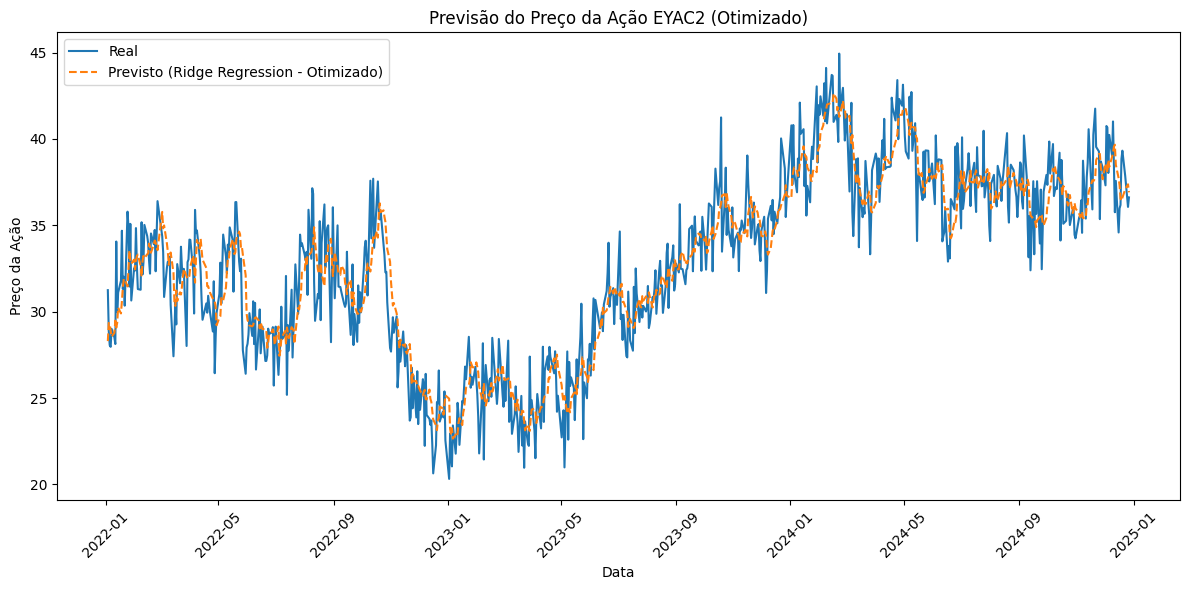

In [584]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit

# Definir o modelo
ridge_model = Ridge()

# Definir os parâmetros para a busca em grade
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],  # Parâmetro de regularização
    'max_iter': [1000, 2000, 3000],  # Número máximo de iterações para a convergência
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']  # Diferentes solvers
}

# Definir a validação cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)

# Configurar o GridSearchCV
grid_search = GridSearchCV(estimator=ridge_model,
                           param_grid=param_grid,
                           cv=tscv,
                           scoring='neg_mean_squared_error',  # Melhor modelo com o menor erro quadrático
                           n_jobs=-1,  # Usar todos os núcleos disponíveis para acelerar o cálculo
                           verbose=2)

# Realizar a busca em grade
grid_search.fit(X_train_scaled, y_train)

# Mostrar os melhores parâmetros encontrados
print("Melhores Parâmetros:", grid_search.best_params_)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Fazer previsões com o melhor modelo
y_pred_ridge_optimized = best_model.predict(X_test_scaled)

# Avaliar o desempenho do modelo otimizado
mae_ridge_optimized = mean_absolute_error(y_test, y_pred_ridge_optimized)
rmse_ridge_optimized = np.sqrt(mean_squared_error(y_test, y_pred_ridge_optimized))
r2_ridge_optimized = r2_score(y_test, y_pred_ridge_optimized)

print("Ridge Regression (Otimizado) - MAE:", mae_ridge_optimized)
print("Ridge Regression (Otimizado) - RMSE:", rmse_ridge_optimized)
print("Ridge Regression (Otimizado) - R²:", r2_ridge_optimized)

# Plotar as previsões vs reais
plt.figure(figsize=(12,6))
plt.plot(test['Date'], y_test, label='Real')
plt.plot(test['Date'], y_pred_ridge_optimized, label='Previsto (Ridge Regression - Otimizado)', linestyle='--')
plt.legend()
plt.title("Previsão do Preço da Ação EYAC2 (Otimizado)")
plt.xlabel('Data')
plt.ylabel('Preço da Ação')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Visualização (melhor modelo, Ridge)

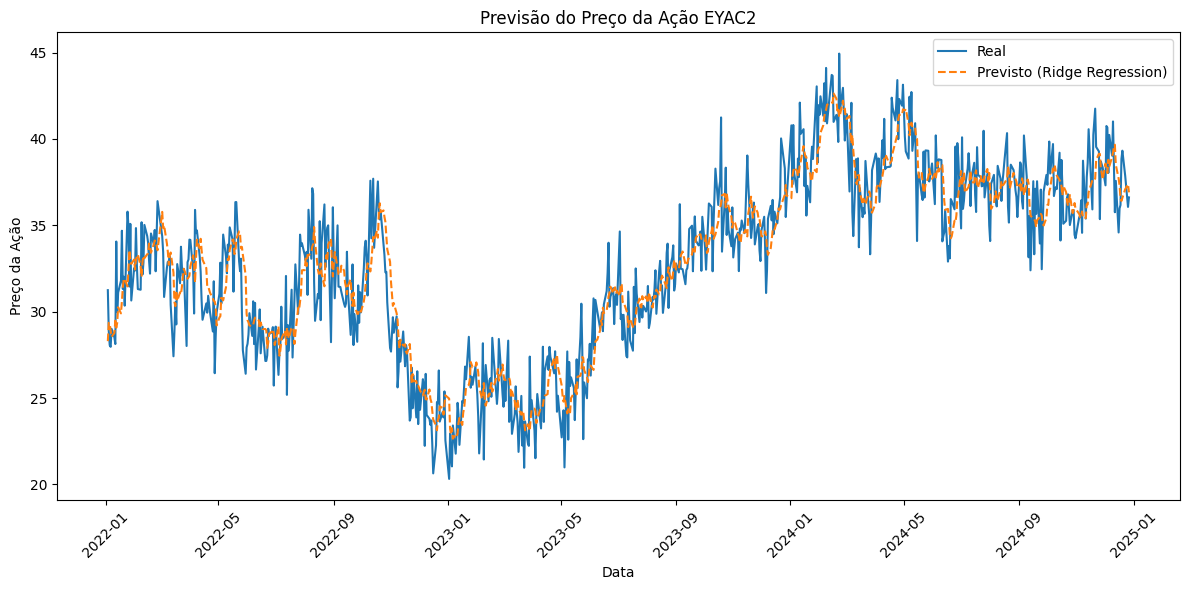

In [585]:
# Plotando as previsões vs reais
plt.figure(figsize=(12,6))
plt.plot(test['Date'], y_test, label='Real')
plt.plot(test['Date'], y_pred_ridge, label='Previsto (Ridge Regression)', linestyle='--')  # Previsões do RandomForest
plt.legend()
plt.title("Previsão do Preço da Ação EYAC2")
plt.xlabel('Data')
plt.ylabel('Preço da Ação')
plt.xticks(rotation=45)  # Para facilitar a leitura das datas
plt.tight_layout()  # Ajustar para que os elementos não se sobreponham
plt.show()


# Erros residuais

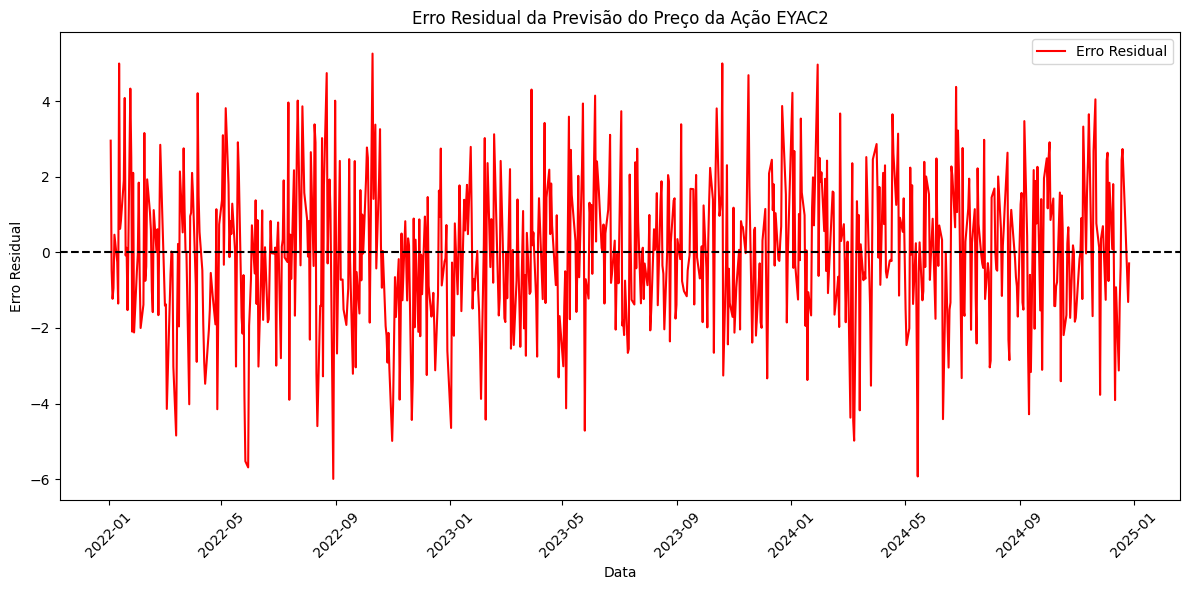

In [609]:
# Calculando os resíduos
residuals = y_test - y_pred_ridge

# Plotando os resíduos
plt.figure(figsize=(12,6))
plt.plot(test['Date'], residuals, label='Erro Residual', color='red')
plt.axhline(0, color='black', linestyle='--')  # Linha horizontal em y=0
plt.legend()
plt.title("Erro Residual da Previsão do Preço da Ação EYAC2")
plt.xlabel('Data')
plt.ylabel('Erro Residual')
plt.xticks(rotation=45)  # Para facilitar a leitura das datas
plt.tight_layout()  # Ajuste para que os elementos não se sobreponham
plt.show()


# Previsões 2025

In [493]:
display(df_model)

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,...,mm7_petro,vol_7_acao,vol_7_ibov,lag1_acao,lag7_acao,lag30_acao,lag90_acao,lag1_petro,lag1_ibov,lag1_ipca
90,2010-05-21,2010-05-21 16:56:00,28.075936,28528898.38,15.558845,70.04,449.43,0.0298,60259.33,-0.090702,...,70.488571,1.152446,2327.439396,29.926240,30.398528,34.659878,37.937621,68.01,58192.08,0.0043
91,2010-05-24,2010-05-24 16:56:00,25.768386,14996109.09,14.378877,70.21,279.82,0.0024,59915.14,-0.130573,...,69.890000,1.748882,1833.964487,28.075936,30.721639,36.336750,37.774220,70.04,60259.33,0.0043
92,2010-05-25,2010-05-25 16:56:00,26.482049,24219409.06,14.419062,68.75,395.40,-0.0208,59184.08,-0.135262,...,69.481429,1.956869,1466.284614,25.768386,29.391340,33.380101,38.805357,70.21,59915.14,0.0043
93,2010-05-26,2010-05-26 16:56:00,26.685337,20468881.44,14.287807,71.51,405.52,0.0401,60190.36,-0.126054,...,69.685714,1.959025,858.492636,26.482049,29.888577,33.515274,36.425929,68.75,59184.08,0.0043
94,2010-05-27,2010-05-27 16:56:00,27.255972,18333085.05,14.567596,74.55,401.81,0.0425,62091.77,-0.066445,...,70.420000,1.394085,1189.144267,26.685337,31.197068,31.726899,35.037787,71.51,60190.36,0.0043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625,2024-12-19,2024-12-19 16:56:00,36.179398,43268468.40,6.687504,69.38,291.66,-0.0091,121187.91,-0.054676,...,69.955714,2.132540,2999.208001,35.980543,39.035292,34.248127,36.096128,70.02,120771.88,0.0052
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,...,69.834286,1.537777,1981.106276,36.179398,41.012756,35.481546,38.442778,69.38,121187.91,0.0052
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,...,69.712857,1.737403,1745.564657,38.845595,38.344346,35.474189,37.702588,69.02,122102.15,0.0052
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,...,69.485714,1.690363,1541.639762,39.320157,35.758705,36.445515,36.414144,68.81,120766.57,0.0052


In [587]:
# Atualizando as features
feature_names = [
    'lag1_acao',  # Mantido por ser o lag mais recente e relevante
    'retorno_acao',  # Retorno da ação
    'retorno_petro',  # Retorno do petróleo
    'mm7_acao',  # Média móvel de 7 dias da ação
    'vol_7_acao',  # Volatilidade de 7 dias da ação
    'Price_Dolar_Petro',  # Preço do petróleo
    'Índice_Ibovespa',  # Índice Ibovespa
]

# Re-treinar o modelo com dados até 2024
train_full = df_model[df_model['Date'] < '2025-01-01']
X_train_full = train_full[feature_names]
y_train_full = train_full['target']

# Se você estiver usando o StandardScaler
scaler = StandardScaler()

# Escalando as features
X_train_full_scaled = scaler.fit_transform(X_train_full)  # Aplique o fit_transform diretamente nas features

# Re-treinar o modelo com o conjunto completo de dados até 2024
ridge_model.fit(X_train_full_scaled, y_train_full)


Ridge()

### Ridge Model

Previsão usando o modelo Ridge Regression (melhor performou no MAE, RMSE e R²)

In [599]:
import numpy as np

# Adicionando ruído à previsão para simular variabilidade
np.random.seed(42)  # Para reprodutibilidade do ruído

# Função para adicionar ruído de 1-2% à previsão
def add_noise(prediction, noise_level=0.02):
    noise = np.random.normal(0, noise_level * prediction)  # Ruído com base no valor da previsão
    return prediction + noise

# Inicializando a lista para armazenar as previsões
future_preds = []

# Re-treinar o modelo com os dados completos até 2024
last_row = train_full.iloc[-1]

# Definindo o número de dias de previsão até 31/12/2025
end_date = pd.to_datetime('2025-12-31')
current_date = last_row['Date']

while current_date <= end_date:
    next_date = current_date + timedelta(days=1)

    # Calcular os lags de forma dinâmica, baseado na última linha de treino
    lag1_acao = last_row['Close_Real_EYAC2']
    lag7_acao = train_full['Close_Real_EYAC2'].shift(7).iloc[-1]
    lag30_acao = train_full['Close_Real_EYAC2'].shift(30).iloc[-1]
    lag90_acao = train_full['Close_Real_EYAC2'].shift(90).iloc[-1]

    # Adicionando as features para o próximo dia
    new_row = {
        'lag1_acao': lag1_acao,
        'retorno_acao': last_row['retorno_acao'],
        'retorno_petro': last_row['retorno_petro'],
        'mm7_acao': last_row['mm7_acao'],
        'vol_7_acao': last_row['vol_7_acao'],
        'Price_Dolar_Petro': last_row['Price_Dolar_Petro'],
        'Índice_Ibovespa': last_row['Índice_Ibovespa'],
    }

    input_df = pd.DataFrame([new_row])
    input_df = input_df[feature_names]

    input_df_scaled = scaler.transform(input_df)

    # Previsão com o modelo Ridge
    y_pred = ridge_model.predict(input_df_scaled)[0]

    # Adicionando ruído à previsão para introduzir variabilidade
    y_pred_with_noise = add_noise(y_pred)

    # Salvar a previsão com ruído
    new_row['Close_Real_EYAC2'] = y_pred_with_noise
    future_preds.append((next_date, y_pred_with_noise))

    # Atualizar a última linha conhecida
    last_row = new_row

    # Atualizar a data
    current_date = next_date

# Exibir as previsões feitas
future_preds_df = pd.DataFrame(future_preds, columns=['Date', 'Predicted_Close_Real_EYAC2'])
display(future_preds_df)

# Salvar previsões em CSV
future_preds_df.to_csv('../../camada_ouro/test_preds_with_noise.csv', index=False)


,Date,Predicted_Close_Real_EYAC2
0,2024-12-28,36.813929
1,2024-12-29,36.541160
2,2024-12-30,37.046626
3,2024-12-31,37.819837
4,2025-01-01,36.726416
...,...,...
365,2025-12-28,36.441008
366,2025-12-29,36.711108
367,2025-12-30,36.625466
368,2025-12-31,36.665874


### Dataframe da previsão

In [600]:
# Criar um DataFrame com as previsões de 2025
future_pred_df = pd.DataFrame(future_preds, columns=['Date', 'Predicted_Close_Real_EYAC2'])


### Visualização da Previsão

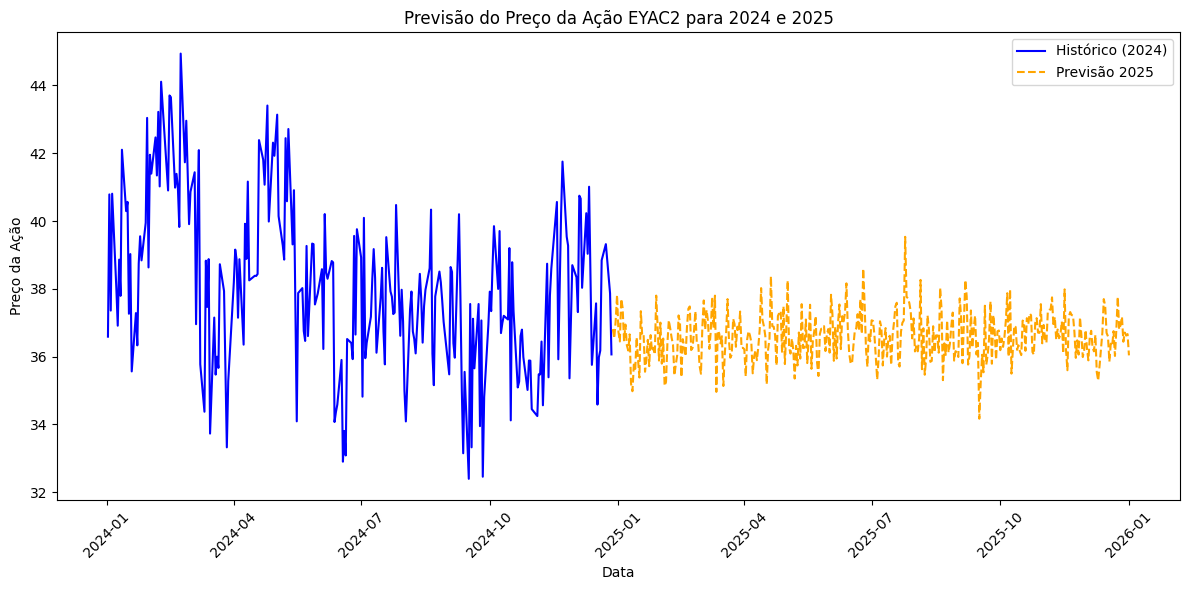

In [603]:
# Plotando a previsão do preço da ação para 2024 e 2025
plt.figure(figsize=(12,6))

# Filtrando os dados históricos para 2024
historical_data = df_model[df_model['Date'] >= '2024-01-01']

# Plotando os dados históricos até 2024
plt.plot(historical_data['Date'], historical_data['Close_Real_EYAC2'], label='Histórico (2024)', color='blue')

# Filtrando as previsões para 2025
future_data = future_pred_df[future_pred_df['Date'] >= '2024-01-01']

# Plotando as previsões para 2025
plt.plot(future_data['Date'], future_data['Predicted_Close_Real_EYAC2'], label='Previsão 2025', linestyle='--', color='orange')

# Adicionando título e rótulos
plt.legend()
plt.title("Previsão do Preço da Ação EYAC2 para 2024 e 2025")
plt.xlabel('Data')
plt.ylabel('Preço da Ação')

# Ajustando a exibição das datas
plt.xticks(rotation=45)

# Ajuste para que os elementos não se sobreponham
plt.tight_layout()

# Mostrar o gráfico
plt.show()
